In [ ]:
from importlib import reload

import numpy as np
from matplotlib import pyplot as plt
import jax
from jax import numpy as jnp
jax.config.update("jax_enable_x64", True)

import base_nudging
import L63
reload(base_nudging)
reload(L63)

jndarray = jnp.ndarray

In [ ]:
def get_initial_values():
    # Initial true state
    u0 = jnp.array([0, 1, -1])

    # Initial simulation state
    un0 = jnp.zeros_like(u0)

    return u0, un0


def simulate(system: L63.System, solver: base_nudging.RK4, dt, T0, Tf, t_relax):
    t0 = T0
    tf = t0 + t_relax
    true0, nudged0 = get_initial_values()

    cs = [system.cs]

    u_errors = []

    while tf <= Tf:
        true, nudged = solver.solve(system, true0, nudged0, t0, tf, dt)

        true0, nudged0 = true[-1], nudged[-1]

        # Update parameters
        system.cs = base_nudging.levenberg_marquardt(
            system, true0[system.observed_slice], nudged0
        )
        cs.append(system.cs)

        t0 = tf
        tf = t0 + t_relax

        # Relative error
        u_errors.append(
            np.linalg.norm(true - nudged)
            / np.linalg.norm(true)
        )

    u_errors = np.array(u_errors)

    # Note `t0` is the actual final time of the simulation (Tf_actual).
    tls = np.linspace(T0, t0, len(u_errors) + 1)

    return jnp.stack(cs), u_errors, tls


def plot(c1s, c2s, c3s, u_errors, γ1, γ2, γ3, tls):
    num_iters = len(c1s)
    ils = np.arange(num_iters)

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    ax = axs[0, 0]
    ax.hlines(γ1, ils[0], ils[-1], label="γ1", color="black")
    ax.plot(ils, c1s, label="c1")
    ax.legend()
    ax.set_title("c1 vs γ1")
    ax.set_xlabel("Iteration number")

    ax = axs[0, 1]
    ax.hlines(γ2, ils[0], ils[-1], label="γ2", color="black")
    ax.plot(ils, c2s, label="c2")
    ax.legend()
    ax.set_title("c2 vs γ2")
    ax.set_xlabel("Iteration number")

    ax = axs[1, 0]
    ax.hlines(γ3, ils[0], ils[-1], label="γ3", color="black")
    ax.plot(ils, c3s, label="c3")
    ax.legend()
    ax.set_title("c3 vs γ3")
    ax.set_xlabel("Iteration number")

    ax = axs[1, 1]
    ax.plot(tls[1:], u_errors)
    ax.set_yscale("log")
    ax.set_title("Relative error in $u$")
    ax.set_xlabel("Time")

    fig.tight_layout()

    return fig, axs

In [ ]:
# System evolution parameters
σ, ρ, β = γ1, γ2, γ3 = 10, 28, 8/3
c1, c2, c3 = γ1, γ2, γ3
c1 *= 1.1
c2 *= 0.9
c3 *= 1.1
μ = 50

bs = jnp.array([])
γs = jnp.array([γ1, γ2, γ3])
cs = jnp.array([c1, c2, c3])

observed_slice = jnp.s_[1:]
system = L63.L63(μ, bs, γs, cs, observed_slice)
solver = base_nudging.RK4(system)

# Simulation parameters
dt = 0.04
T0, Tf = 0, 4000
t_relax = 1

cs, u_errors, tls = simulate(
    system, solver, dt, T0, Tf, t_relax
)

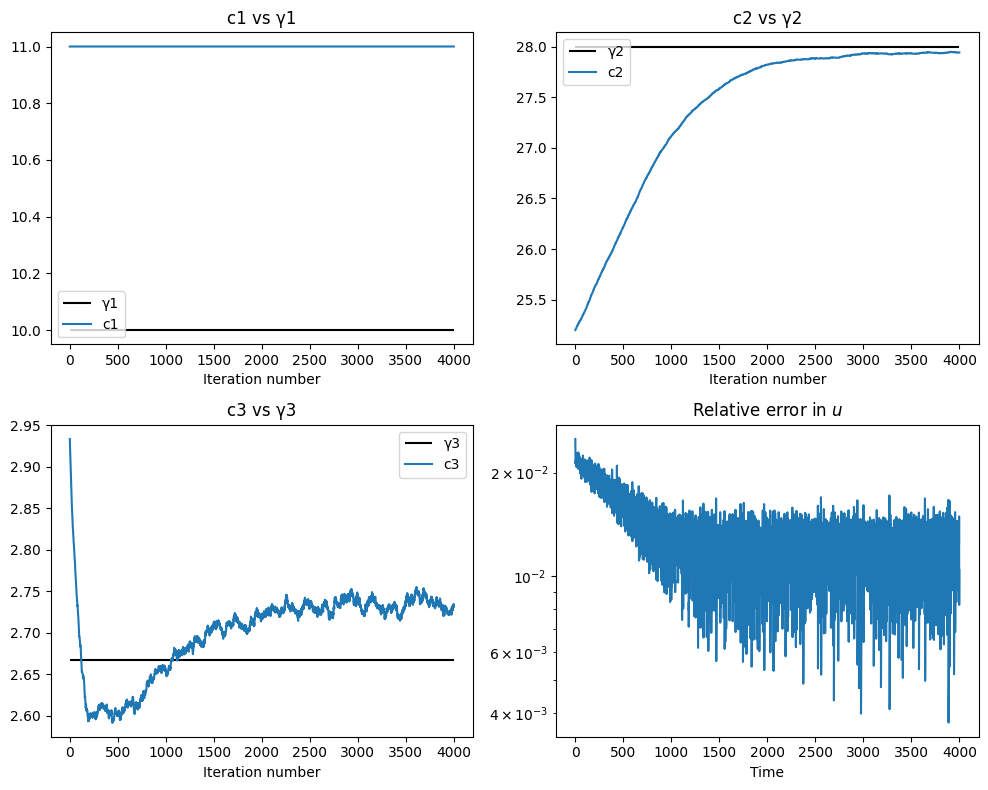

In [ ]:
fig, axs = plot(cs.T[0], cs.T[1], cs.T[2], u_errors, γ1, γ2, γ3, tls)
plt.show()